In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, 
                            batch_first = True)
        
        nn.init.orthogonal_(self.lstm.weight_ih_l0, gain = np.sqrt(2))
        nn.init.orthogonal_(self.lstm.weight_hh_l0, gain = np.sqrt(2))
        
    def forward(self, x):
        device = x.device
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        return out[:, -1, :].unsqueeze(1)

In [3]:
class LSTMDecoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(LSTMDecoder, self).__init__()
        self.output_size = output_size
        self.lstm = nn.LSTM(hidden_size, hidden_size,
                            batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.LeakyReLU()
        
        nn.init.orthogonal_(self.lstm.weight_ih_l0, gain = np.sqrt(2))
        nn.init.orthogonal_(self.lstm.weight_hh_l0, gain = np.sqrt(2))
        
    def forward(self, x):
        hidden_size = x.size(-1)
        device = x.device
        h0 = torch.zeros(1, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), hidden_size).to(device)
        
        lstm_out, _ = self.lstm(x, (h0, c0))
        fc_out = self.fc(self.relu(lstm_out))
        return self.relu(fc_out)

In [4]:
class LSTMAutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMAutoEncoder, self).__init__()
        self.encoder = LSTMEncoder(
            input_size, hidden_size
        )
        self.decoder = LSTMDecoder(
            hidden_size, input_size
        )
        self.relu = nn.LeakyReLU()
        
    def forward(self, x):
        seq_size = x.size(1)
        encoded_x = self.encoder(x).expand(-1, seq_size, -1)
        decoded_x = self.decoder(encoded_x)
        return decoded_x

In [5]:
device = torch.device('cuda')

hidden_size = 512
seq_length = 40
batch_size = 8
loading = 1.
lr = 0.001

# (batch, seq, [x, y, w, h])
x = torch.randint(low = 10, high = 320, 
                  size = (batch_size, seq_length, 4)
                 ).float()
x = x / 320.
#x = torch.randn(batch_size, seq_length, 4) * loading
x = x.to(device)

model = LSTMAutoEncoder(input_size = 4, 
                        hidden_size = hidden_size)
model.to(device)

L2_loss = nn.MSELoss()
L1_loss = nn.L1Loss()

enc_optimizer = torch.optim.Adam(
    params = filter(lambda p: p.requires_grad, model.encoder.parameters()),
    lr = lr
)
dec_optimizer = torch.optim.Adam(
    params = filter(lambda p: p.requires_grad, model.decoder.parameters()),
    lr = lr
)

enc_scheduler = StepLR(enc_optimizer, step_size = 300, gamma = 0.1)
dec_scheduler = StepLR(dec_optimizer, step_size = 300, gamma = 0.1)

In [6]:
# NO reverse 
# L2 loss
# Leaky ReLU makes loss curve less bumpy than ReLU
# Adam has better optimization on loss
# set decoder to be (hidden_size, hidden_size) ==> fc(hidden_size, input_size)

# IoU
epoch_n = 1000

model.train()
losses = []
for epoch in range(epoch_n):
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}')
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    
    seq_length = x.size(1)
    outputs = model(x)
    
    #inv_idx = torch.arange(seq_length -1, -1, -1).long()
    #x[:, inv_idx, :] / outputs
    #loss = L1_loss(outputs, x[:, inv_idx, :])
    
    # RMSE
    loss = L2_loss(outputs, x)
    loss = torch.sqrt(loss)
    
#     loss = L1_loss(
#         torch.log(outputs),
#         torch.log(x[:, inv_idx, :])
#     )
    losses.append(loss)
    
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    
    enc_scheduler.step()
    dec_scheduler.step()
    
    #print(f'[Epoch: {epoch}] Loss: {loss}')

Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900


tensor(0.2380, device='cuda:0', grad_fn=<SqrtBackward>)

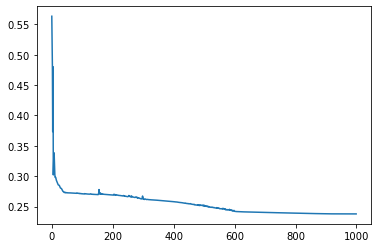

In [7]:
plt.plot(losses)
losses[-1]

In [12]:
x[0, 3:6]

tensor([[0.4500, 0.3969, 0.6000, 0.3562],
        [0.6313, 0.3688, 0.7844, 0.6875],
        [0.6812, 0.1594, 0.5688, 0.0312]], device='cuda:0')

In [13]:
outputs[0, 3:6]

tensor([[0.5955, 0.3894, 0.6545, 0.5854],
        [0.5800, 0.4482, 0.6576, 0.4894],
        [0.4659, 0.4182, 0.5466, 0.3553]], device='cuda:0',
       grad_fn=<SliceBackward>)

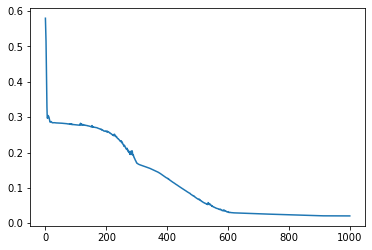

In [7]:
plt.plot(losses)

In [8]:
losses[-1]

tensor(0.0208, device='cuda:0', grad_fn=<SqrtBackward>)

In [9]:
losses[-1]

tensor(0.0024, device='cuda:0', grad_fn=<SqrtBackward>)

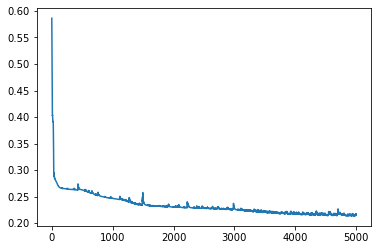

In [7]:
plt.plot(losses);

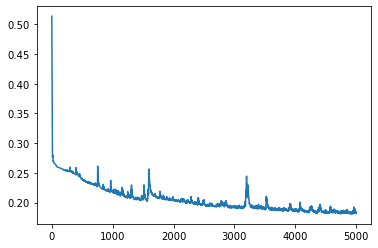

In [7]:
plt.plot(losses);